### Given the pretrained encoder, visualize the model latent features (conditional on class, for different datasets)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

import logging
import time
import pickle
from copy import deepcopy
import numpy as np
import sys
import os

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
from importlib import import_module
import os

# Path to the parent directory
parent_directory_path = Path.cwd().parent  # Adjust this path as necessary

# Iterate through each child directory in the parent directory
for child in parent_directory_path.iterdir():
    if child.is_dir():  # Make sure it's a directory
        sys.path.append(str(child))

# For each child directory in the parent directory
for child in parent_directory_path.iterdir():
    if child.is_dir():  # Make sure it's a directory
        # List all .py files in the directory
        for file in child.glob('*.py'):
            # Import the module
            # Note: os.path.splitext(file.name)[0] gets the module name without the .py extension
            module_name = os.path.splitext(file.name)[0]
            imported_module = import_module(module_name)
            print(f"Imported {module_name} from {child.name}")

Imported pretrain_models from train
Imported ssl_model_pruning from prune
Imported ntl-prune from prune
Imported admm from prune
Imported pruner from prune
Imported pruning_utils from prune
Imported __init__ from prune
Imported admm_encoder from prune
Imported prune_model from prune
Imported syn from utils
Imported similarity from utils


ImportError: attempted relative import with no known parent package

In [4]:
from models.encoders import ResNetEncoder, ResNetClassifier
from prune.pruner import load_base_model
from metrics.LogME import LogME
from metrics.SFDA import SFDA_Score

In [5]:
num_classes = 10
model = torchvision.models.resnet18(pretrained=True)
# change the output layer to 10 classes (for digits dataset)
model.fc = nn.Linear(512, num_classes)

/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/ruyi/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [252]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import Subset

def get_cifar_dataloader(ratio=1.0):
    """
    Get the CIFAR10 dataloader
    """
    # Data loading code for cifar10 
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        ),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010],
        ),
    ])

    train_dataset = datasets.CIFAR10(
        root="../../data/",
        train=True,
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(len(train_dataset) * ratio)
    print(f"Using the sample size of {subset_size}.")

    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = datasets.CIFAR10(
        root="../../data/",
        train=False,
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader

def get_stl_dataloader(ratio=0.1):
    """
    Get the STL10 dataloader
    """
    # Data loading code for STL10 
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.ToTensor(),
    ])

    train_dataset = datasets.STL10(
        root="../../data/",
        split='train',
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(len(train_dataset)*ratio)
    print(f"Using sample size of {subset_size}.")
                      
    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = datasets.STL10(
        root="../../data/",
        split='test',
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader

def get_mnist_dataloader(ratio=1.0):
    """
    Get the MNIST dataloader
    """
    # Data loading code for MNIST 
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.Grayscale(num_output_channels=3),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.1307],
            std=[0.3081],
        ),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.Grayscale(num_output_channels=3),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.1307],
            std=[0.3081],
        ),
    ])

    train_dataset = datasets.MNIST(
        root="../../data/",
        train=True,
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(len(train_dataset)*ratio)
    print(f"Using sample size of {subset_size}.")
                      
    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = datasets.MNIST(
        root="../../data/",
        train=False,
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader

def get_usps_dataloader(ratio=1.0):
    """
    Get the USPS dataloader
    """
    # Data loading code for USPS 
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.Grayscale(num_output_channels=3),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.1307],
            std=[0.3081],
        ),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.Grayscale(num_output_channels=3),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.1307],
            std=[0.3081],
        ),
    ])

    train_dataset = datasets.USPS(
        root="../../data/",
        train=True,
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(len(train_dataset)*ratio)
    print(f"Using sample size of {subset_size}.")
                      
    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = datasets.USPS(
        root="../../data/",
        train=False,
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader

def get_mnistm_dataloader(ratio=1.0):
    """
    Get the MNISTM dataloader
    """
    # Data loading code for MNISTM 
    from utils.mnistm import MNISTM
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        ),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        ),
    ])

    train_dataset = MNISTM(
        root="../../data/",
        train=True,
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(60000 * ratio)# for example, 5000 samples

    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = MNISTM(
        root="../../data/",
        train=False,
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader

def get_svhn_dataloader(ratio=1.0):
    """
    Get the SVHN dataloader
    """
    # Data loading code for SVHN 
    train_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.RandomHorizontalFlip(),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        ),
    ])

    val_transform = transforms.transforms.Compose([
        transforms.Resize(32),
        transforms.transforms.ToTensor(),
        transforms.transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5],
        ),
    ])

    train_dataset = datasets.SVHN(
        root="../../data/",
        split='train',
        download=True,
        transform=train_transform,
    )

    # Define the size of the subset
    subset_size = int(len(train_dataset)*ratio)
    print(f"Using sample size of {subset_size}.")
                      
    # Create a random subset for training
    indices = np.random.permutation(len(train_dataset))
    train_indices = indices[:subset_size]
    train_subset = Subset(train_dataset, train_indices)

    val_dataset = datasets.SVHN(
        root="../../data/",
        split='test',
        download=True,
        transform=val_transform,
    )

    train_loader = torch.utils.data.DataLoader(
        train_subset,
        batch_size=64,
        shuffle=True,
        num_workers=10,
    )

    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        batch_size=64,
        shuffle=False,
        num_workers=10,
    )

    return train_loader, val_loader


In [273]:
model_name = 'resnet18'
source_domain = 'svhn'
target_domain = 'mnistm'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_model_dir = f'../../base_models/{model_name}-{source_domain}.pth'
model.load_state_dict(torch.load(base_model_dir))
model.to(device)
resnet_encoder = ResNetEncoder(model)
resnet_classifier = ResNetClassifier(model)


In [254]:
ratio = 1.0
if source_domain == 'cifar10':
    source_trainloader, source_testloader = get_cifar_dataloader(ratio)
elif source_domain == 'stl':
    source_trainloader, source_testloader = get_stl_dataloader(ratio)
elif source_domain == 'mnist':
    source_trainloader, source_testloader = get_mnist_dataloader(ratio)
elif source_domain == 'usps':
    source_trainloader, source_testloader = get_usps_dataloader(ratio)
elif source_domain == 'mnistm':
    source_trainloader, source_testloader = get_mnistm_dataloader(ratio)
elif source_domain == 'svhn':
    source_trainloader, source_testloader = get_svhn_dataloader(ratio)

if target_domain == 'cifar10':
    target_trainloader, target_testloader = get_cifar_dataloader(ratio)
elif target_domain == 'stl':
    target_trainloader, target_testloader = get_stl_dataloader(ratio)
elif target_domain == 'mnist':
    target_trainloader, target_testloader = get_mnist_dataloader(ratio)
elif target_domain == 'usps':
    target_trainloader, target_testloader = get_usps_dataloader(ratio)
elif target_domain == 'mnistm':
    target_trainloader, target_testloader = get_mnistm_dataloader(ratio)
elif target_domain == 'svhn':
    target_trainloader, target_testloader = get_svhn_dataloader(ratio)
    


../../data/MNISTM/processed/mnist_m_train.pt
../../data/MNISTM/processed/mnist_m_test.pt
Using sample size of 60000.


In [255]:
arch = 'resnet18'
encoder_path = f'../../saved_models/{arch}/{source_domain}_to_{target_domain}/admm_encoder.pth'
classifier_path = f'../../saved_models/{arch}/{source_domain}_to_{target_domain}/admm_source_classifier.pth'
mask_path  = f'../../saved_models/{arch}/{source_domain}_to_{target_domain}/admm_mask.pth'
admm_pickle_path = f'../../saved_models/{arch}/{source_domain}_to_{target_domain}/admm_pruner.pkl'

mask_dict = torch.load(mask_path)
resnet_encoder = torch.load(encoder_path)
resnet_classifier = torch.load(classifier_path)


In [200]:
# build an all-one mask 
all_one_mask_dict = {}
for name, param in resnet_encoder.named_parameters():
    if name in mask_dict:
        all_one_mask_dict[name] = torch.ones_like(mask_dict[name])

mask_dict = all_one_mask_dict

In [256]:
total_params = 0
total_nonzero_params = 0
for name, param in resnet_encoder.named_parameters():
    total_params += param.numel()
    if name in mask_dict:
        total_nonzero_params += torch.sum(mask_dict[name]).item()
print(f"Model sparsity: {1-total_nonzero_params/total_params}")

Model sparsity: 0.9900074370250754


/tmp/ipykernel_3611/749406349.py:45: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


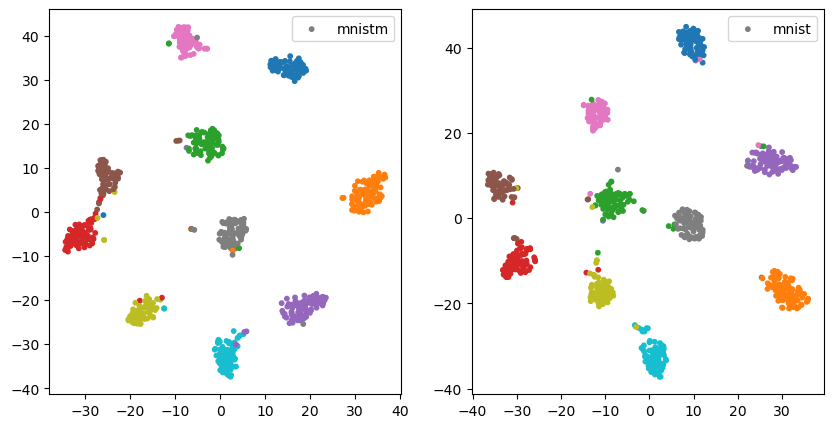

In [274]:
# The feature space of source domain 
source_features = []
source_labels = []
for i, (inputs, labels) in enumerate(source_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    source_features.append(features)
    source_labels.append(labels)
    if i > 10:
        break
source_features = torch.cat(source_features, dim=0)
source_labels = torch.cat(source_labels, dim=0)

# The feature space of target domain
target_features = []
target_labels = []
for i, (inputs, labels) in enumerate(target_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    target_features.append(features)
    target_labels.append(labels)
    if i > 10:
        break
target_features = torch.cat(target_features, dim=0)
target_labels = torch.cat(target_labels, dim=0)



## Visualize the feature space of both domains using TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
n_samples = source_features.shape[0]
source_features = source_features.cpu().detach().numpy().reshape(n_samples, -1)
target_features = target_features.cpu().detach().numpy().reshape(n_samples, -1)
source_labels = source_labels.cpu().detach().numpy()
target_labels = target_labels.cpu().detach().numpy()

source_features = tsne.fit_transform(source_features)
target_features = tsne.fit_transform(target_features)
plt.subplots(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(source_features[:, 0], source_features[:, 1], c=source_labels, cmap='tab10', s=10, label=source_domain)
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(target_features[:, 0], target_features[:, 1], c=target_labels,  cmap='tab10', s=10,  label=target_domain)
plt.legend()
plt.show()


In [269]:
# The feature space of source domain 
source_features = []
source_labels = []
for i, (inputs, labels) in enumerate(source_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    source_features.append(features)
    source_labels.append(labels)
    if i > 10:
        break
source_features = torch.cat(source_features, dim=0)
source_labels = torch.cat(source_labels, dim=0)

source_features = source_features.cpu().detach().numpy().reshape(n_samples, -1)
source_labels = source_labels.cpu().detach().numpy()

logme = LogME(regression=False)
score = logme.fit(np.array(source_features), np.array(source_labels))
score

0.48186862123659147

In [275]:
# The feature space of source domain 
source_features = []
source_labels = []
for i, (inputs, labels) in enumerate(source_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    source_features.append(features)
    source_labels.append(labels)
    if i > 10:
        break
source_features = torch.cat(source_features, dim=0)
source_labels = torch.cat(source_labels, dim=0)

source_features = source_features.cpu().detach().numpy().reshape(n_samples, -1)
source_labels = source_labels.cpu().detach().numpy()

sfda_score = SFDA_Score(source_features, source_labels)
sfda_score

Shrinkage: 1.1012843053234779e-05
Shrinkage: 1.1012843053234779e-05


0.9999999999647091

In [276]:
# The feature space of source domain 
target_features = []
target_labels = []
for i, (inputs, labels) in enumerate(target_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    target_features.append(features)
    target_labels.append(labels)
    if i > 10:
        break
target_features = torch.cat(target_features, dim=0)
target_labels = torch.cat(target_labels, dim=0)

target_features = target_features.cpu().detach().numpy().reshape(n_samples, -1)
target_labels = target_labels.cpu().detach().numpy()

logme = LogME(regression=False)
score = logme.fit(np.array(target_features), np.array(target_labels))
score



1.0501559584110685

In [277]:
# The feature space of source domain 
target_features = []
target_labels = []
for i, (inputs, labels) in enumerate(target_testloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    target_features.append(features)
    target_labels.append(labels)
    if i > 10:
        break
target_features = torch.cat(target_features, dim=0)
target_labels = torch.cat(target_labels, dim=0)

target_features = target_features.cpu().detach().numpy().reshape(n_samples, -1)
target_labels = target_labels.cpu().detach().numpy()

sfda_score = SFDA_Score(target_features, target_labels)
sfda_score

Shrinkage: 1.324591707862925e-06
Shrinkage: 1.324591707862925e-06


1.0

/tmp/ipykernel_3611/1394232757.py:43: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, 2, 1)


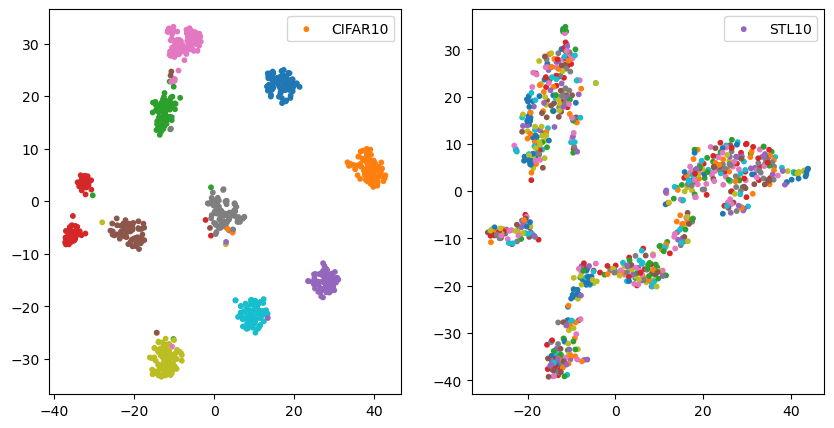

In [209]:
# The feature space of source domain 
source_features = []
source_labels = []
for i, (inputs, labels) in enumerate(source_trainloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    source_features.append(features)
    source_labels.append(labels)
    if i > 10:
        break
source_features = torch.cat(source_features, dim=0)
source_labels = torch.cat(source_labels, dim=0)

# The feature space of target domain
target_features = []
target_labels = []
for i, (inputs, labels) in enumerate(target_trainloader):
    inputs = inputs.cuda()
    labels = labels.cuda()
    features = resnet_encoder(inputs, mask_dict)
    target_features.append(features)
    target_labels.append(labels)
    if i > 10:
        break
target_features = torch.cat(target_features, dim=0)
target_labels = torch.cat(target_labels, dim=0)

## Visualize the feature space of both domains using TSNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=0)
n_samples = source_features.shape[0]
source_features = source_features.cpu().detach().numpy().reshape(n_samples, -1)
target_features = target_features.cpu().detach().numpy().reshape(n_samples, -1)
source_labels = source_labels.cpu().detach().numpy()
target_labels = target_labels.cpu().detach().numpy()

source_features = tsne.fit_transform(source_features)
target_features = tsne.fit_transform(target_features)
plt.subplots(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(source_features[:, 0], source_features[:, 1], c=source_labels, cmap='tab10', s=10, label='CIFAR10')
plt.legend()
plt.subplot(1, 2, 2)
plt.scatter(target_features[:, 0], target_features[:, 1], c=target_labels,  cmap='tab10', s=10,  label='STL10')
plt.legend()
plt.show()



### Finetune the source model

In [30]:
from copy import deepcopy

nepochs = 20
lr = 0.001

source_encoder = deepcopy(resnet_encoder)
source_classifier = deepcopy(resnet_classifier)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")
source_encoder.to(device)
source_classifier.to(device)

# fine-tune the encoder and classifier
# optimizer = torch.optim.SGD([param for name, param in encoder.named_parameters() if param.requires_grad] + [param for name, param in classifier.named_parameters() if param.requires_grad], lr=lr, momentum=0.9)
optimizer = torch.optim.Adam([param for name, param in source_encoder.named_parameters() if param.requires_grad] + [param for name, param in source_classifier.named_parameters() if param.requires_grad], lr=lr, weight_decay=0.0008)
criterion = torch.nn.CrossEntropyLoss()

source_encoder.train()
source_classifier.train()
for epoch in range(nepochs):
    total_loss = 0.0
    count = 0
    for inputs, labels in source_trainloader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        features = source_encoder(inputs, mask_dict)
        outputs  = source_classifier(features)
        loss = criterion(outputs, labels)
        loss.backward()
        total_loss += loss.item()
        count += len(labels)
        optimizer.step()

        # apply the mask to the model
        for name, param in source_encoder.named_parameters():
            if name in mask_dict:
                param.data = param.data * mask_dict[name]
                # set the gradient to zero
                param.grad = param.grad * mask_dict[name]

    print(f"Epoch {epoch}: {total_loss/count}")

    # # how many percentage parameters are adjusted 
    # changed = 0
    # total = 0
    # for name, param in encoder.named_parameters():
    #     if param.requires_grad:
    #         changed += torch.sum(param.grad != 0).item()
    #         total += param.numel()
    # print(f"Percentage of changed parameters: {changed/total}")

Using device cuda:0


Epoch 0: 0.009019649915993213
Epoch 1: 0.006393932961523533
Epoch 2: 0.0060387517687678334
Epoch 3: 0.006068195552825928
Epoch 4: 0.006194202884882688


KeyboardInterrupt: 